In [1]:
import sys
sys.path.append("../")

import gym
import d4rl
from PIL import Image
import numpy as np

from diffuser.utils.rendering import Maze2dRenderer

No module named 'flow'
/home/cspark/anaconda3/envs/diffuser/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: May 20 2022 19:45:31
/home/cspark/diffuser/diffuser/utils/config.py:21: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  class Config(collections.Mapping):


In [2]:
env_name = 'maze2d-open-v1'
# env_name = 'maze2d-umaze-v1'

In [3]:
# Create the environment
env = gym.make(env_name).unwrapped

init Maze Env: [0. 0.]


In [4]:
org_dataset = env.get_dataset()

load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:00<00:00, 33.61it/s]


In [5]:
print(org_dataset.keys())
print(org_dataset['rewards'].shape)
print(org_dataset['observations'].shape)


dict_keys(['actions', 'info/goal', 'info/qpos', 'info/qvel', 'observations', 'rewards', 'terminals', 'timeouts'])
(673501,)
(673501, 4)


In [6]:
print(org_dataset['observations'])
print(org_dataset['info/goal'])
print(np.where(org_dataset['terminals'])[0].shape)
print(np.where(org_dataset['timeouts'])[0].shape)
print(np.where(org_dataset['terminals'])[0][:10])

[[ 1.11872102  1.12180898 -0.16264927 -0.06379822]
 [ 1.11879391  1.12355416  0.00728888  0.17451756]
 [ 1.12075401  1.12291354  0.19600991 -0.06406191]
 ...
 [ 2.67586774  4.47640399  2.10055248  5.15278189]
 [ 2.69920488  4.5273919   2.33371356  5.09879057]
 [ 2.72438654  4.57729405  2.51816618  4.99021459]]
[[3.07445718 4.97616175]
 [3.07445718 4.97616175]
 [3.07445718 4.97616175]
 ...
 [3.01235774 5.03816227]
 [3.01235774 5.03816227]
 [3.01235774 5.03816227]]
(5000,)
(0,)
[ 133  263  399  530  661  793  921 1051 1187 1322]


In [7]:
# Get dataset and make it as replay buffer
from diffuser.datasets import GoalDataset, UnconditionedDataset
dataset = UnconditionedDataset(env=env_name, termination_penalty=None, 
                      horizon=128,
                      normalizer='LimitsNormalizer', 
                      preprocess_fns=[],
                      use_padding=False,
                      max_path_length=40000
                      )

load datafile: 100%|██████████| 8/8 [00:00<00:00, 35.79it/s]


[ datasets/buffer ] Finalized replay buffer | 5000 episodes
[ datasets/buffer ] Fields:
    actions: (5000, 40000, 2)
    info/goal: (5000, 40000, 2)
    info/qpos: (5000, 40000, 2)
    info/qvel: (5000, 40000, 2)
    observations: (5000, 40000, 4)
    rewards: (5000, 40000, 1)
    terminals: (5000, 40000, 1)
    timeouts: (5000, 40000, 1)
    next_observations: (5000, 40000, 4)
    normed_observations: (5000, 40000, 4)
    normed_actions: (5000, 40000, 2)


In [8]:
import torch

dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, num_workers=1, shuffle=True, pin_memory=True)

In [10]:
batch = next(iter(dataloader))
print(batch.trajectories.shape)

torch.Size([25, 128, 6])


In [11]:
batch = next(iter(dataloader))
observations = batch.trajectories[:, : , -4:]
observations = dataset.normalizer.unnormalize(observations, 'observations')

/home/cspark/diffuser/diffuser/utils/rendering.py:77: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))


Saved 25 samples to: dummy.png


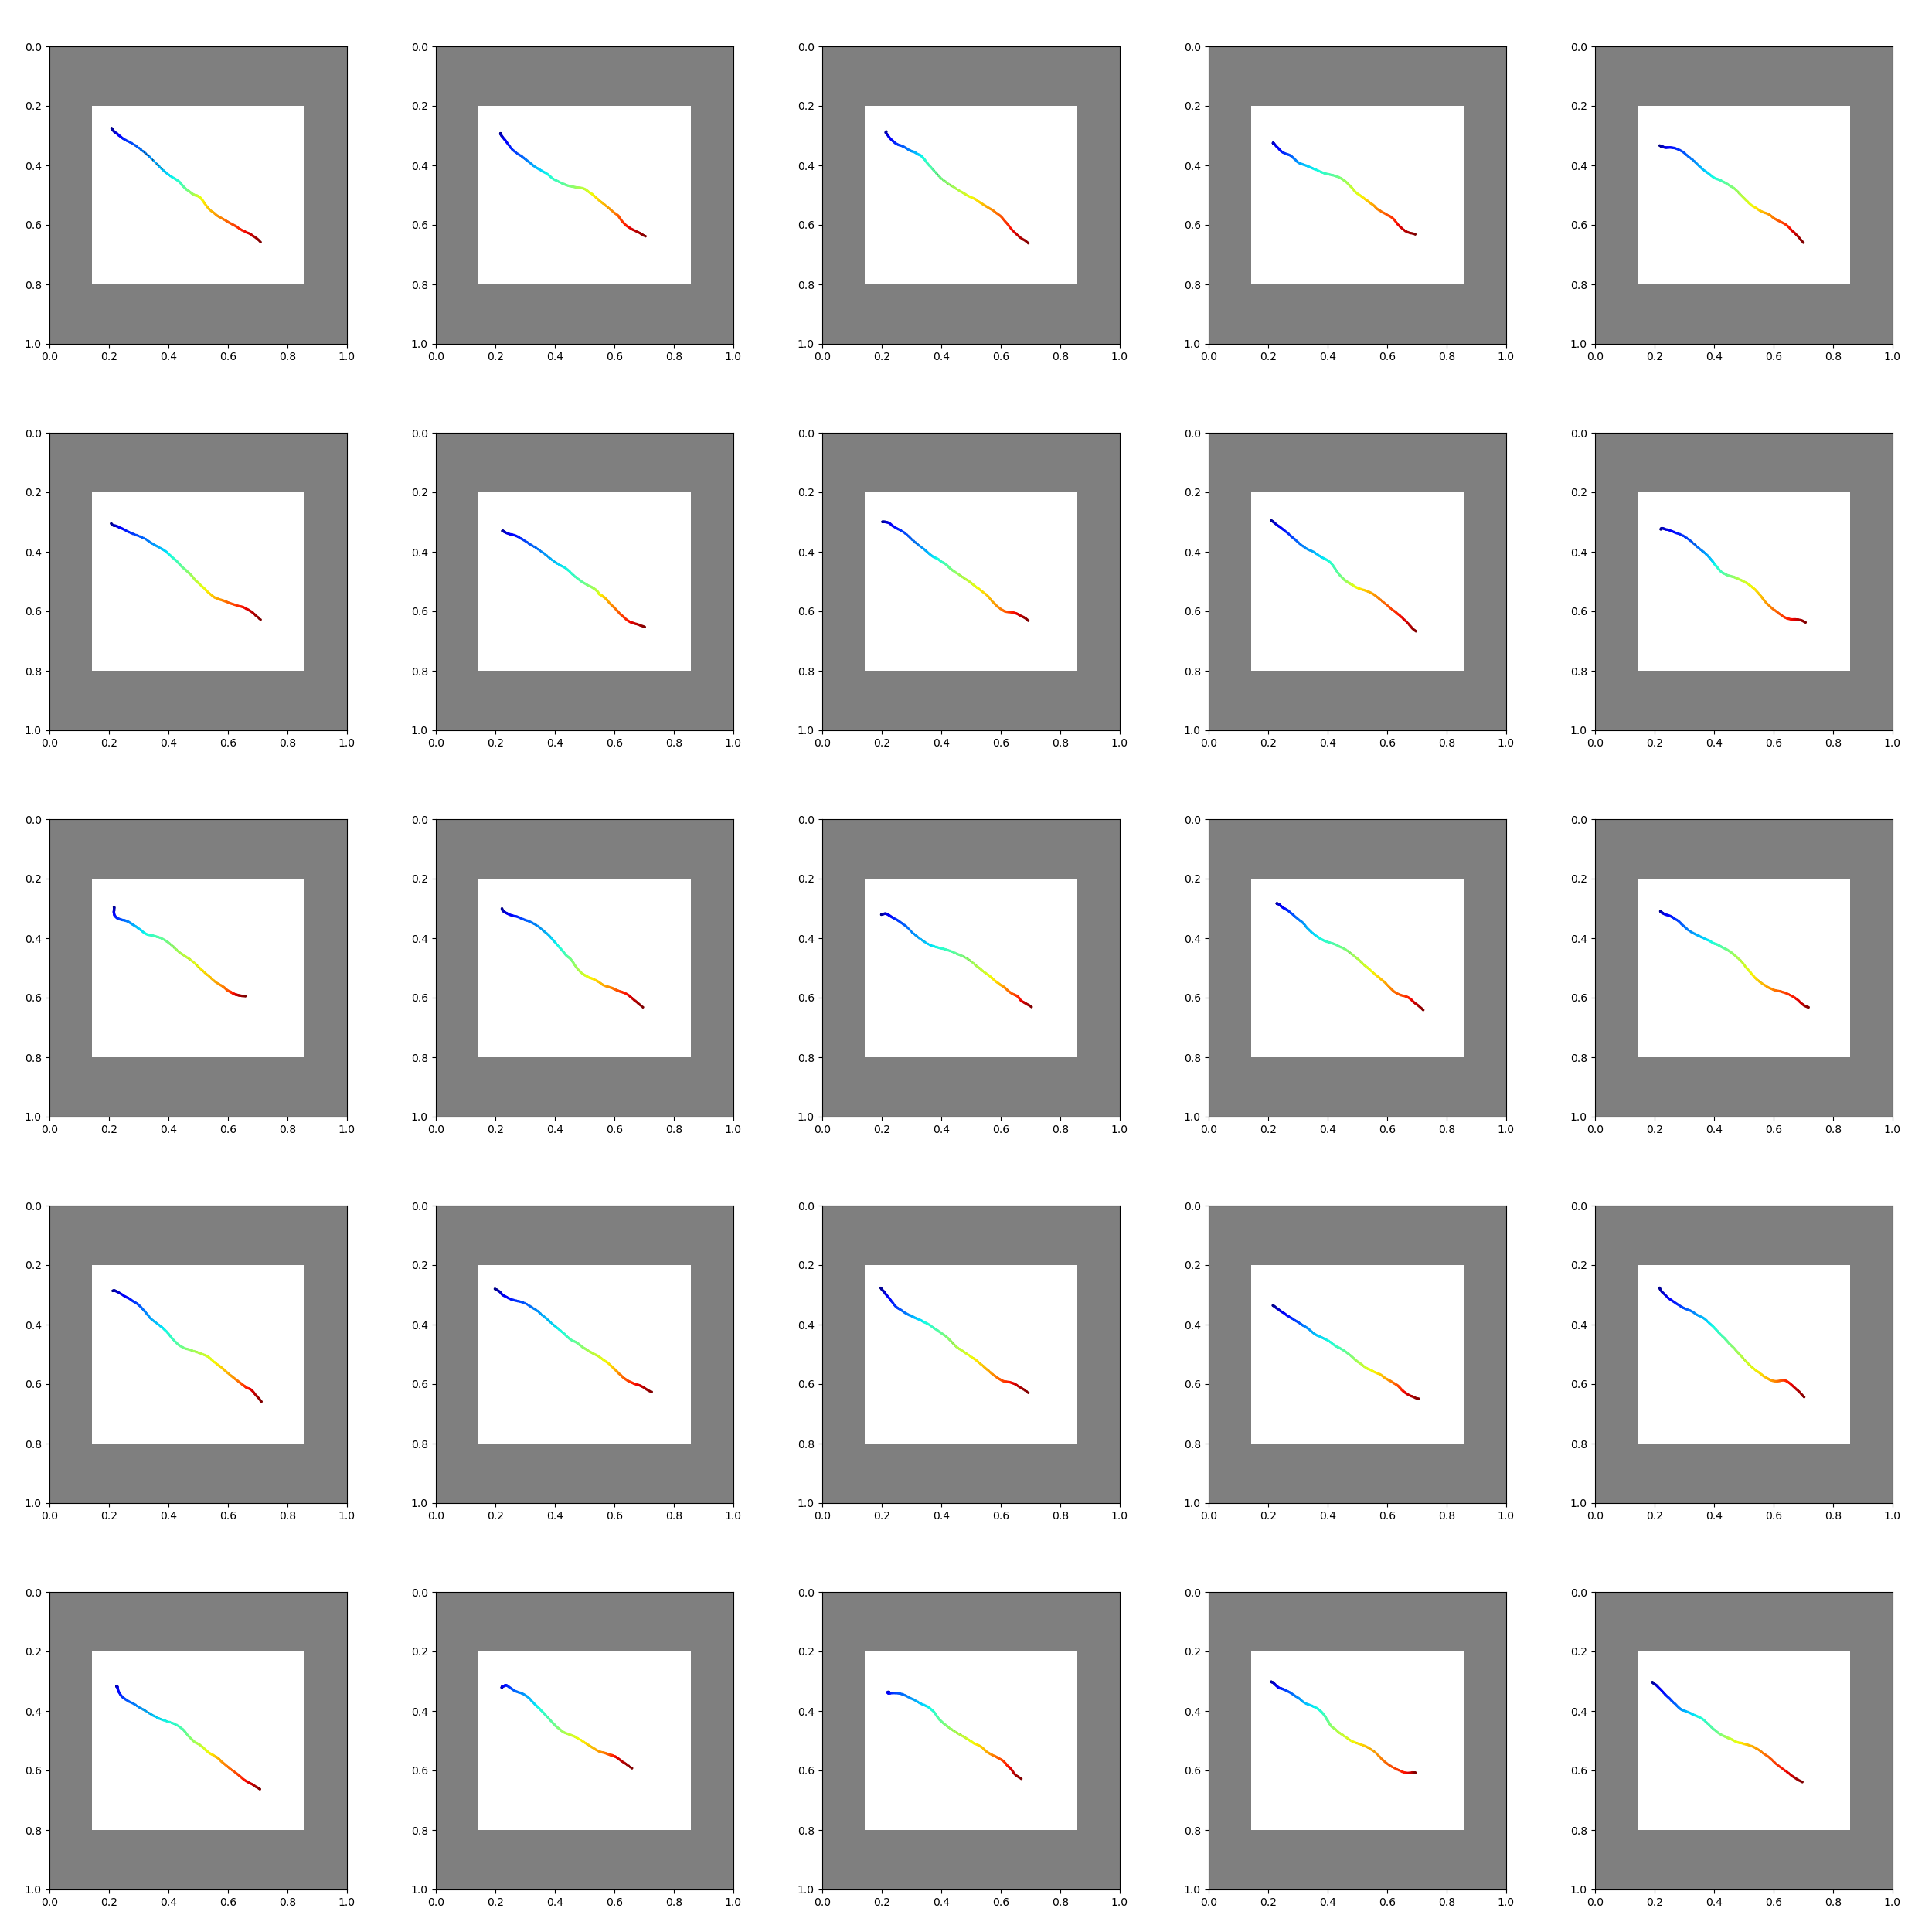

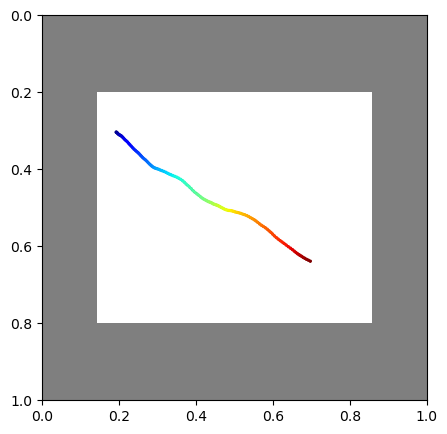

In [12]:
renderer = Maze2dRenderer(env_name)
renderer.composite(savepath='dummy.png', paths=observations[:, :, :2], ncol=5)